# Stadistical Patter Recognition Proyect

### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples
from geopy.distance import geodesic
from geopy.distance import distance
import geopy.distance
import geopandas as gpd
from shapely.geometry import Point
from geopy import distance

### Data

In [4]:
lista = ["/content/drive/MyDrive/datos_abiertos_2022_07.csv", "/content/drive/MyDrive/datos_abiertos_2022_08.csv",
         "/content/drive/MyDrive/datos_abiertos_2022_09.csv", "/content/drive/MyDrive/datos_abiertos_2022_10.csv",
         "/content/drive/MyDrive/datos_abiertos_2022_11.csv", "/content/drive/MyDrive/datos_abiertos_2022_12.csv",
         "/content/drive/MyDrive/datos_abiertos_2023_01.csv", "/content/drive/MyDrive/datos_abiertos_2023_02.csv",
         "/content/drive/MyDrive/datos_abiertos_2023_03.csv", "/content/drive/MyDrive/datos_abiertos_2023_04.csv",
         "/content/drive/MyDrive/datos_abiertos_2023_05.csv"]

df = pd.read_csv('/content/drive/MyDrive/datos_abiertos_2022_06.csv', encoding='latin-1')

In [5]:
for i in range(len(lista)):
    df2 = pd.read_csv(lista[i], encoding='latin-1')

    if df2.columns[3] != 'Año_de_nacimiento':
        # Cambiar el nombre de la segunda columna a 'Año_de_nacimiento'
        df2.rename(columns={df2.columns[3]: 'Año_de_nacimiento'}, inplace=True)

    df = pd.concat([df, df2])

In [6]:
df['Inicio_del_viaje'] = pd.to_datetime(df['Inicio_del_viaje'])
df['Fin_del_viaje'] = pd.to_datetime(df['Fin_del_viaje'])

# Extrae la columna de hora
df['Hora_Inicio'] = df['Inicio_del_viaje'].dt.time
df['Hora_Fin'] = df['Fin_del_viaje'].dt.time

# Calcula la duración del viaje
df['Duracion'] = (df['Fin_del_viaje'] - df['Inicio_del_viaje']).dt.total_seconds()/60

# Cambiar F y M por 0 y 1, respectivamente
df['Genero'] = df['Genero'].replace({'F': 0, 'M': 1})

# Calcular la edad en lugar de tener el año de nacimiento
df['Edad'] = 2022 - df['Año_de_nacimiento']

In [7]:
print(df['Año_de_nacimiento'].min(), df['Año_de_nacimiento'].max())
df = df.loc[(1930<df['Año_de_nacimiento']) & (df['Año_de_nacimiento']<2008)]

1.0 2022.0


### First analisis

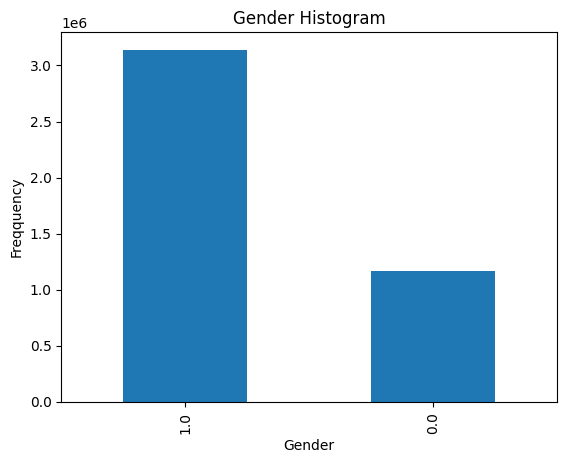

In [9]:
# Gender Histogram
df['Genero'].value_counts().plot.bar()

# Graph
plt.xlabel('Gender')
plt.ylabel('Freqquency')
plt.title('Gender Histogram')

plt.show()

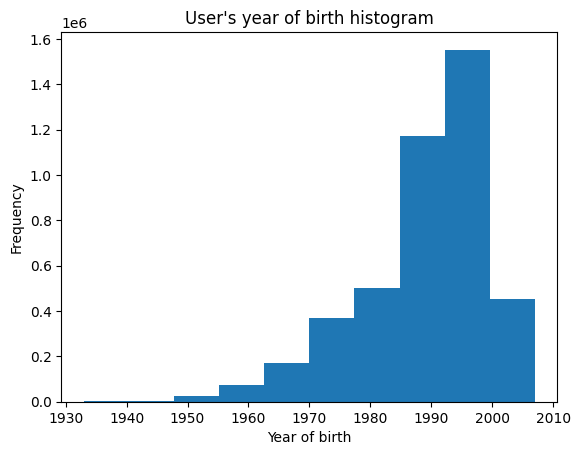

In [10]:
# User's year of birth histogram
plt.hist(df['Año_de_nacimiento'], bins=10)

# Graph
plt.xlabel('Year of birth')
plt.ylabel('Frequency')
plt.title('User\'s year of birth histogram')

plt.show()

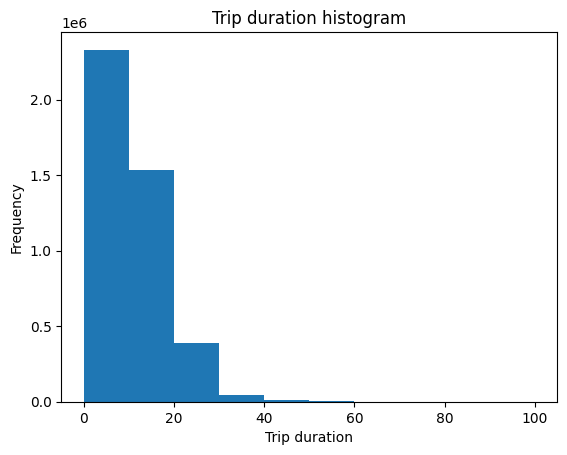

In [11]:
plt.hist(df['Duracion'][df['Duracion']<100])

# Graph
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
plt.title('Trip duration histogram')

plt.show()

In [12]:
print(len(df[df['Duracion']>100]))
df = df.loc[df['Duracion']<100]

# Defining hour of trip begining and ending
df['Hora_Fin'] = [valor.strftime('%H') for valor in df['Hora_Fin']]
df['Hora_Inicio'] = [valor.strftime('%H') for valor in df['Hora_Inicio']]

df['Hora_Inicio'] = df['Hora_Inicio'].astype(int)
df['Hora_Fin']    = df['Hora_Fin'].astype(int)

1206


In [13]:
df_distance = pd.read_csv('/content/drive/MyDrive/nomenclatura_2023_05.csv', encoding='latin-1')
df_distance = df_distance[['id', 'latitude', 'longitude']]
df_distance.head()

id   latitude   longitude
0   2  20.666378 -103.348820
1   3  20.667228 -103.366000
2   4  20.667690 -103.368252
3   5  20.691750 -103.362550
4   6  20.681151 -103.338863

In [14]:
# Supongamos que tienes dos DataFrames: df_trayectos y df_ubicaciones
# Fusionar los DataFrames por los IDs de inicio y partida
df_fusionado = pd.merge(df[['Origen_Id','Destino_Id']], df_distance, left_on='Origen_Id', right_on='id', how='left')
df_fusionado = pd.merge(df_fusionado, df_distance, left_on='Destino_Id', right_on='id', how='left', suffixes=('_inicio', '_final'))

# Assuming you have a DataFrame called df with columns 'lat_a', 'lon_a', 'lat_b', 'lon_b'
# Create Point objects for each pair of coordinates
# Create Point objects for each pair of coordinates
geometry_inicial = [Point(lat, lon) for lat, lon in zip(df_fusionado['latitude_inicio'], df_fusionado['longitude_inicio'])]
geometry_final = [Point(lat, lon) for lat, lon in zip(df_fusionado['latitude_final'], df_fusionado['longitude_final'])]

# Create a GeoDataFrame with the Point objects
gdf = gpd.GeoDataFrame(df_fusionado, geometry=geometry_inicial)

# Set the coordinate reference system (CRS) if needed
gdf.crs = 'EPSG:4326' # Assuming WGS84 coordinate system

# Calculate the distance between the points in meters
gdf['distance'] = gdf['geometry'].distance(gpd.GeoSeries(geometry_final))

gdf.head()

<ipython-input-14-81d8145d9dd9>:19: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance'] = gdf['geometry'].distance(gpd.GeoSeries(geometry_final))
<ipython-input-14-81d8145d9dd9>:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf['distance'] = gdf['geometry'].distance(gpd.GeoSeries(geometry_final))


Origen_Id  Destino_Id  id_inicio  latitude_inicio  longitude_inicio  \
0         21          43         21        20.678835       -103.368045   
1         34          34         34        20.677263       -103.344908   
2         18         170         18        20.682007       -103.372642   
3         38         181         38        20.676078       -103.356458   
4        289         118        289        20.717800       -103.383380   

   id_final  latitude_final  longitude_final                     geometry  \
0        43       20.676710      -103.370660  POINT (20.67883 -103.36804)   
1        34       20.677263      -103.344908  POINT (20.67726 -103.34491)   
2       170       20.688610      -103.365814  POINT (20.68201 -103.37264)   
3       181       20.689250      -103.336100  POINT (20.67608 -103.35646)   
4       118       20.737087      -103.401285  POINT (20.71780 -103.38338)   

   distance  
0  0.003370  
1  0.000000  
2  0.009498  
3  0.024248  
4  0.026317

In [15]:
df['Distancia'] = gdf['distance']

In [16]:
df_new = df[['Hora_Fin', 'Hora_Inicio' ,'Duracion', 'Edad', 'Genero', 'Distancia']]
df_new = df_new.dropna()

In [18]:
graf = sns.pairplot(df_new[['Hora_Fin', 'Hora_Inicio' ,'Duracion', 'Edad', 'Distancia']])
#plt.savefig(r"C:\Users\merce\Downloads\Graf_dispersion.png")

Error in callback <function _draw_all_if_interactive at 0x798d3afea680> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x798d3afe9900> (for post_execute):


KeyboardInterrupt: 

# ***K-means***

2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


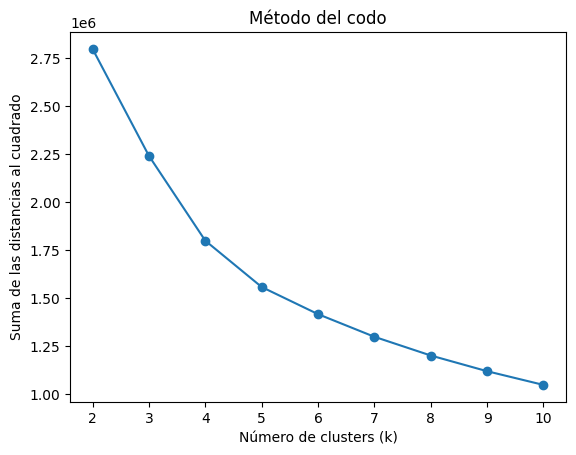

Número óptimo de clusters (método de la silueta): 2


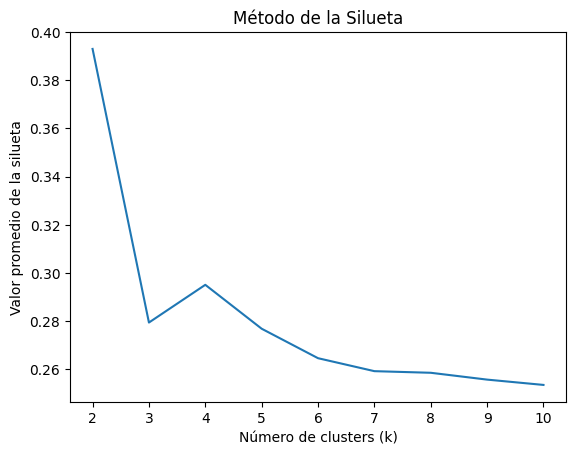

In [19]:
# Calcular la suma de las distancias al cuadrado para diferentes valores de k
distortions = []
silhouette_scores = []

sample = df_new.sample(n=int(len(df_new)*0.005))
k_values = range(2, 11)
for k in k_values:
    print(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sample)
    distortions.append(kmeans.inertia_)

    # Calcular el valor de la silueta para los datos
    silhouette_avg = silhouette_score(sample, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Graficar la suma de las distancias al cuadrado en función de k
plt.plot(k_values, distortions, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de las distancias al cuadrado')
plt.title('Método del codo')
plt.show()


# Encontrar el valor de k que maximiza el promedio de la silueta
best_k = k_values[np.argmax(silhouette_scores)]

# Imprimir el número óptimo de clusters
print("Número óptimo de clusters (método de la silueta):", best_k)

# Visualizar el gráfico de la silueta
plt.plot(k_values, silhouette_scores)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Valor promedio de la silueta')
plt.title('Método de la Silueta')
plt.show()

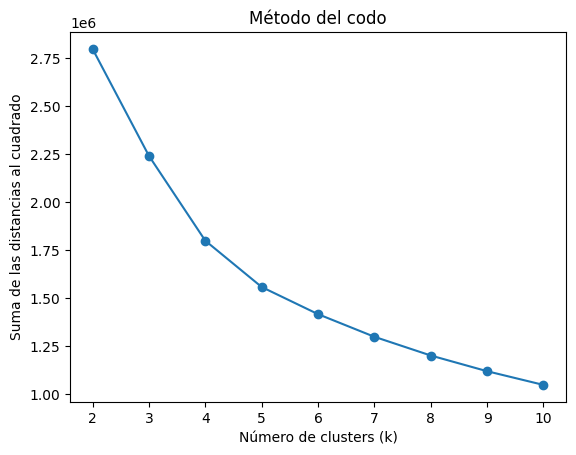

In [20]:
graph = plt.plot(k_values, distortions, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de las distancias al cuadrado')
plt.title('Método del codo')
plt.savefig(r"C:\Users\merce\Downloads\Metodo_codo.png")

El "codo" en el gráfico se refiere al punto en el que la reducción de la SSD se vuelve menos significativa a medida que aumenta k. Este punto se considera una buena elección para el número de clusters, ya que proporciona un equilibrio entre la compresión de los datos y la simplicidad del modelo. En otras palabras, el codo representa un punto en el que agregar más clusters ya no mejora significativamente la calidad del clustering.

Por lo tanto, al utilizar el método del codo, se busca seleccionar el valor de k en el punto del gráfico donde la reducción de la SSD ya no es sustancialmente mayor. Esto implica encontrar un equilibrio entre la calidad del clustering y la simplicidad del modelo.

No parece haber k óptimo.

In [21]:
# Crear un objeto de KMeans
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_new)
labels = kmeans.labels_

# Obtener los centroides de los clusteres
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## ***PCA***

In [22]:
# Realizar reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(df_new)

In [23]:
componentes    = pca.components_
df_cargas      = pd.DataFrame(componentes, columns = df_new.columns)
variance_ratio = pca.explained_variance_ratio_

# Calcula la varianza acumulada
cumulative_variance = np.cumsum(variance_ratio)

# Visualiza las cargas de componentes
print(df_cargas)

# Imprime la varianza explicada de cada componente
for i, ratio in enumerate(variance_ratio):
    print(f"Componente {i+1}: {ratio}")

# Imprime la varianza acumulada
print("Varianza acumulada:")
for i, variance in enumerate(cumulative_variance):
    print(f"Componentes 1-{i+1}: {variance}")

   Hora_Fin  Hora_Inicio  Duracion      Edad    Genero     Distancia
0 -0.035595    -0.036636  0.040249  0.997869  0.005344  7.248039e-07
1  0.185364     0.174120  0.966771 -0.025983 -0.001337 -2.195696e-06
2 -0.682940    -0.682910  0.252335 -0.059607 -0.000878  8.660684e-06
Componente 1: 0.5351514538379563
Componente 2: 0.25076646481550513
Componente 3: 0.21034705800082246
Varianza acumulada:
Componentes 1-1: 0.5351514538379563
Componentes 1-2: 0.7859179186534614
Componentes 1-3: 0.9962649766542838


In [24]:
df_new['labels'] = labels

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


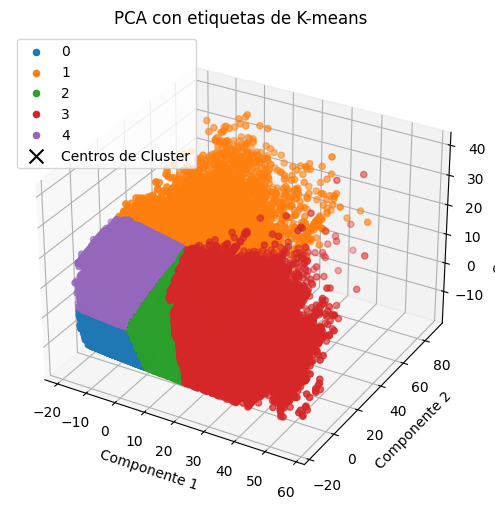

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
reduced_data = pd.DataFrame(reduced_data, columns=['Componente 1', 'Componente 2', 'Componente 3'])
reduced_data['labels'] = labels

for label in set(df_new['labels']):
    subset = reduced_data[reduced_data['labels'] == label]
    ax.scatter(subset['Componente 1'], subset['Componente 2'], subset['Componente 3'], label=label)

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='black', marker='x', s=100, label='Centros de Cluster')

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend()
plt.title('PCA con etiquetas de K-means')
plt.show()
# plt.savefig(r"C:\Users\merce\Downloads\PCA_k{}.png".format(k))

## ***TSNE***

In [26]:
sample_df = df_new.sample(n=int(len(df_new)*0.0005))

In [27]:
features = sample_df[['Genero', 'Hora_Fin', 'Hora_Inicio' ,'Duracion', 'Edad']]
tsne = TSNE(n_components=3, perplexity=20, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create a DataFrame with the t-SNE results and gender labels
tsne_df = pd.DataFrame(tsne_results, columns=['Componente 1', 'Componente 2', 'Componente 3'])
tsne_df['labels'] = sample_df['labels'].reset_index(drop=True)

In [28]:
# Plotear t-SNE en 3D
# Crear el gráfico interactivo en 3D con Plotly
fig = go.Figure(data=go.Scatter3d(
    x=tsne_df['Componente 1'],
    y=tsne_df['Componente 2'],
    z=tsne_df['Componente 3'],
    mode='markers',
    marker=dict(
        size=2,
        color=tsne_df['labels'],
        colorscale='Viridis',
        opacity=0.9
    )
))

# Configurar los ejes y el título del gráfico
fig.update_layout(scene=dict(
    xaxis_title='Componente 1',
    yaxis_title='Componente 2',
    zaxis_title='Componente 3'
))

fig.update_layout(title_text='t-SNE Visualization')
fig.update_layout(width=800, height=600)

# Mostrar el grÃ¡fico interactivo
fig.show()

## Análisis de ***K-Means***

Genero          0.693648
Hora_Fin       18.073067
Hora_Inicio    17.955445
Duracion        7.924491
Edad           26.636137
Distancia       0.013567
dtype: float64
Genero          0.697521
Hora_Fin       15.468962
Hora_Inicio    15.226301
Duracion       22.217562
Edad           29.583247
Distancia       0.013575
dtype: float64
Genero          0.794336
Hora_Fin       14.586488
Hora_Inicio    14.484659
Duracion        8.619087
Edad           40.039911
Distancia       0.013595
dtype: float64
Genero          0.819385
Hora_Fin       13.538369
Hora_Inicio    13.388590
Duracion       11.533498
Edad           55.056737
Distancia       0.013627
dtype: float64
Genero          0.700486
Hora_Fin        9.241478
Hora_Inicio     9.172105
Duracion        8.054804
Edad           27.185319
Distancia       0.013666
dtype: float64


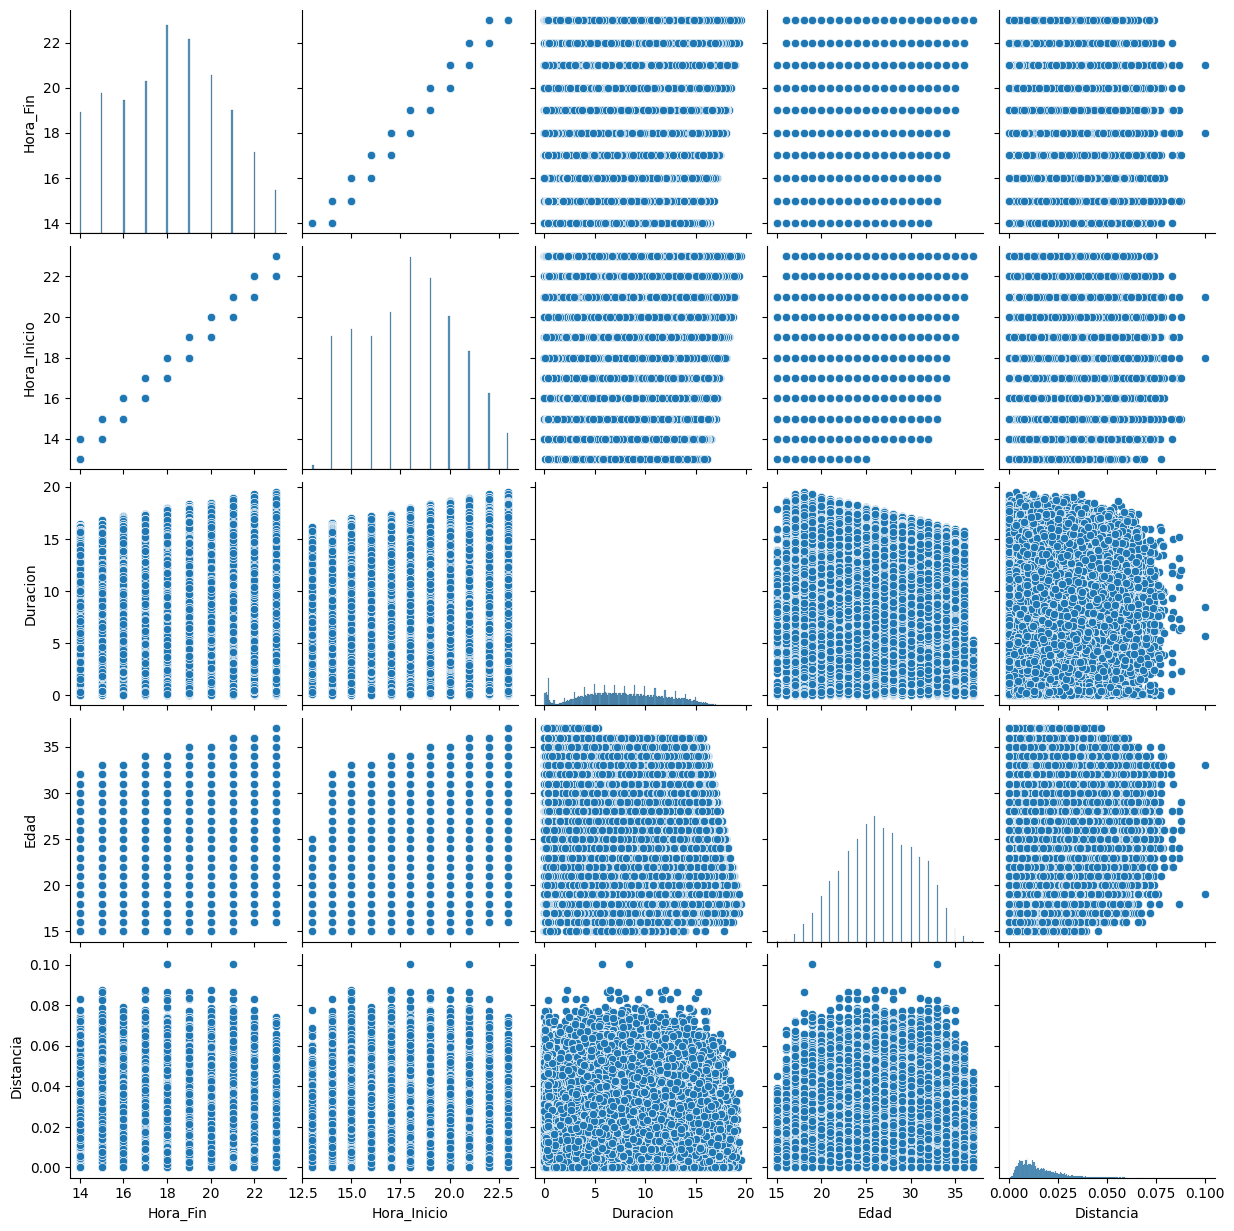

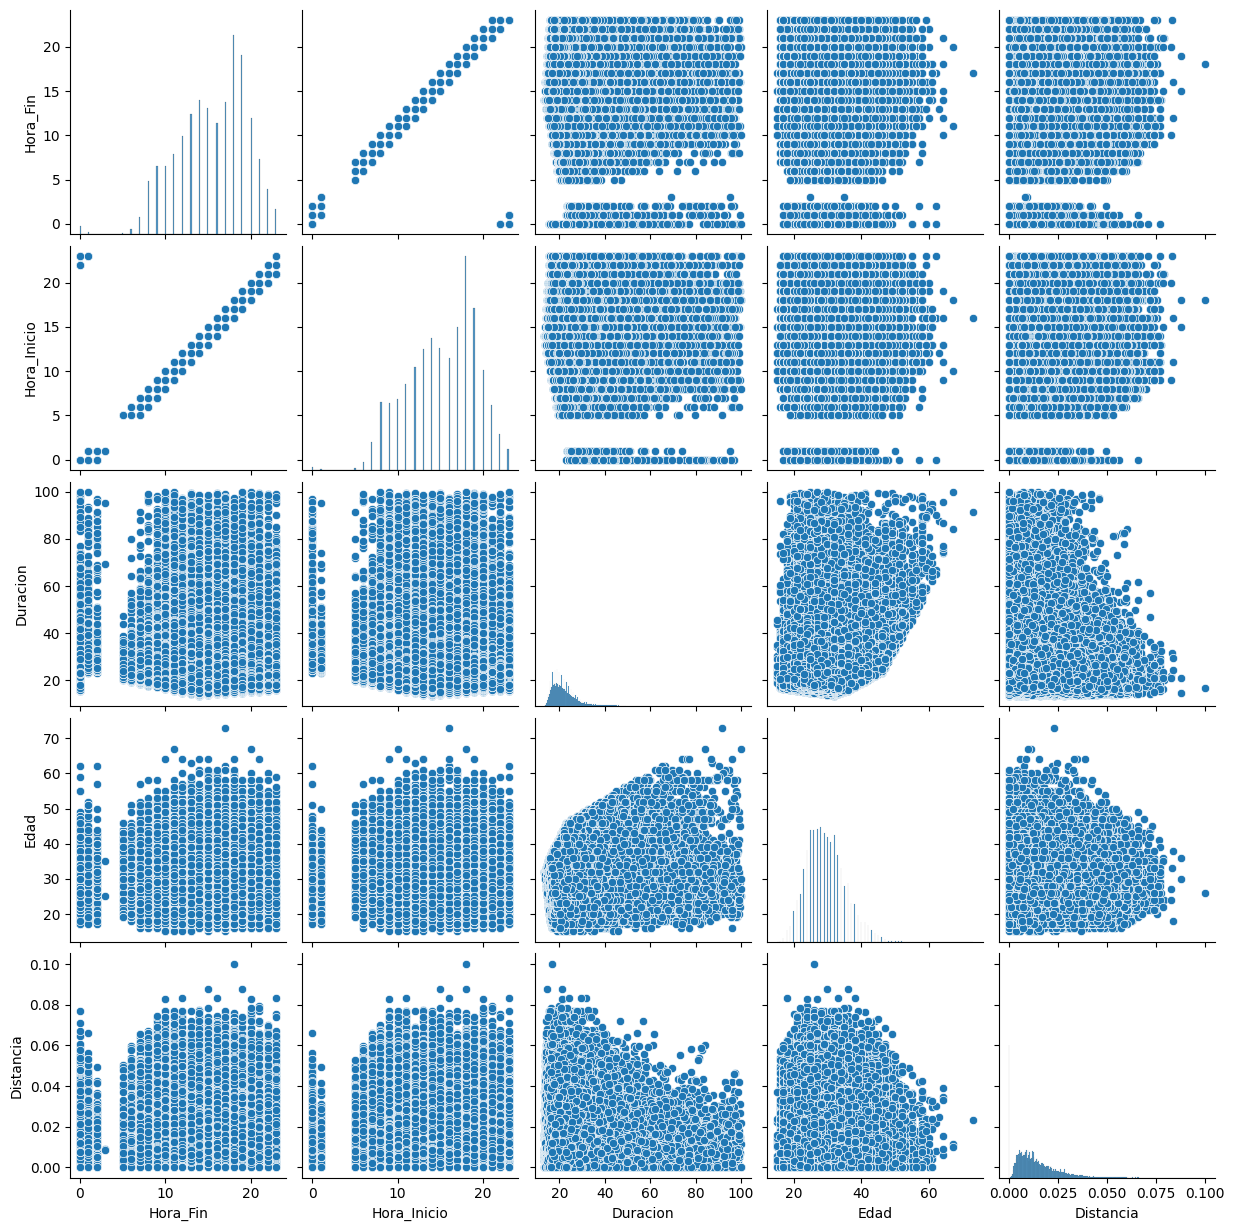

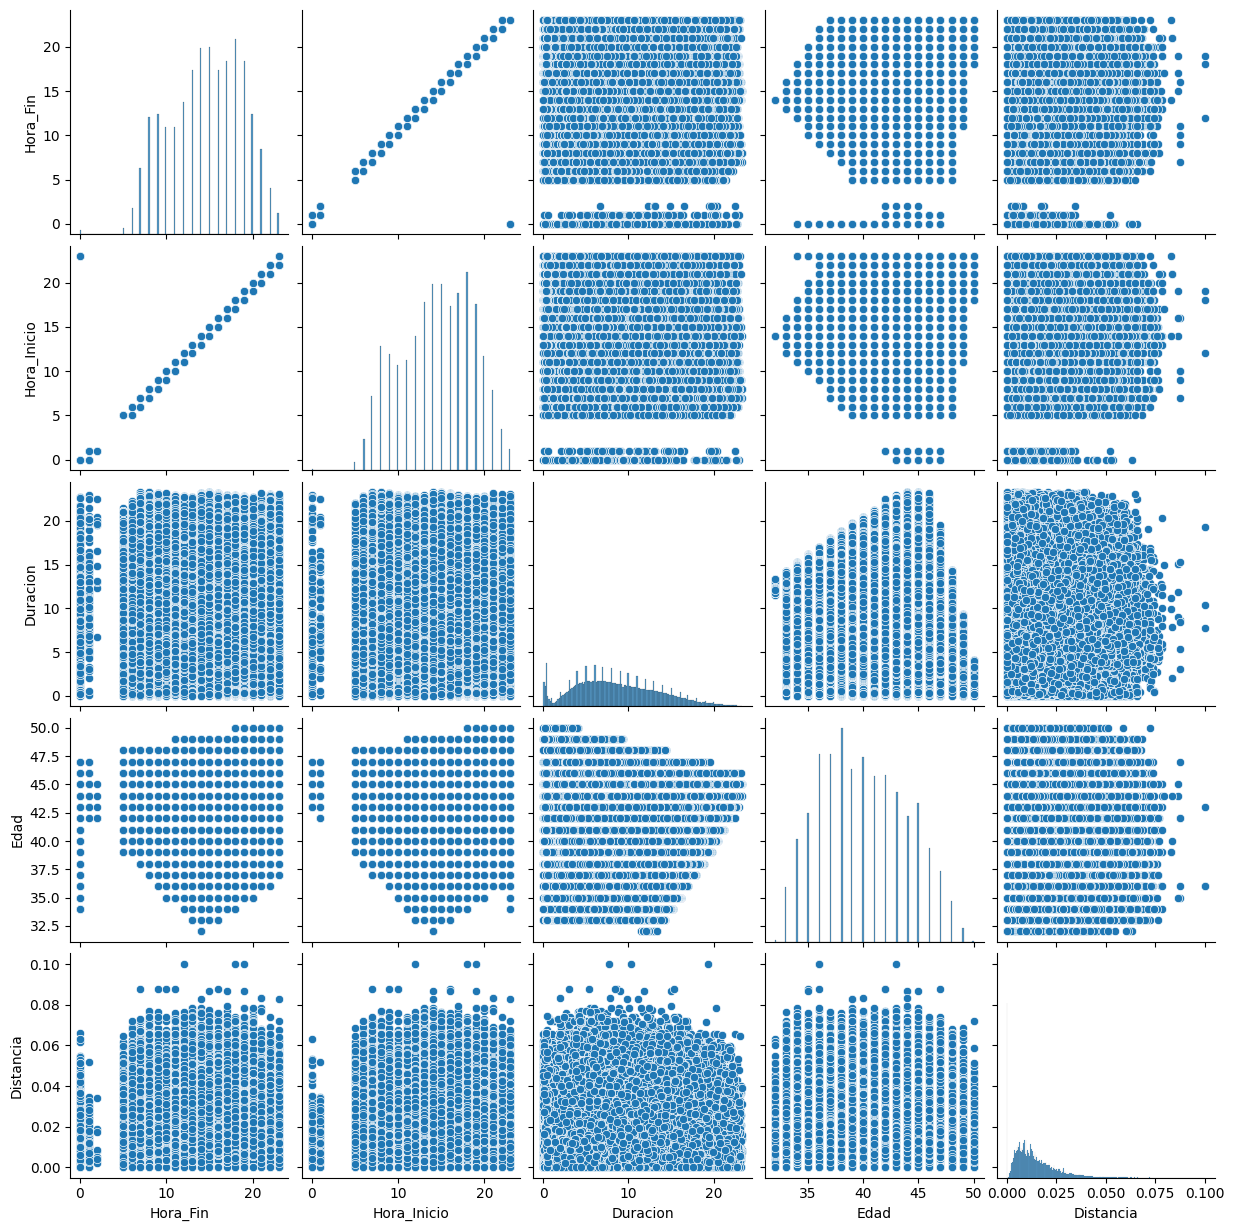

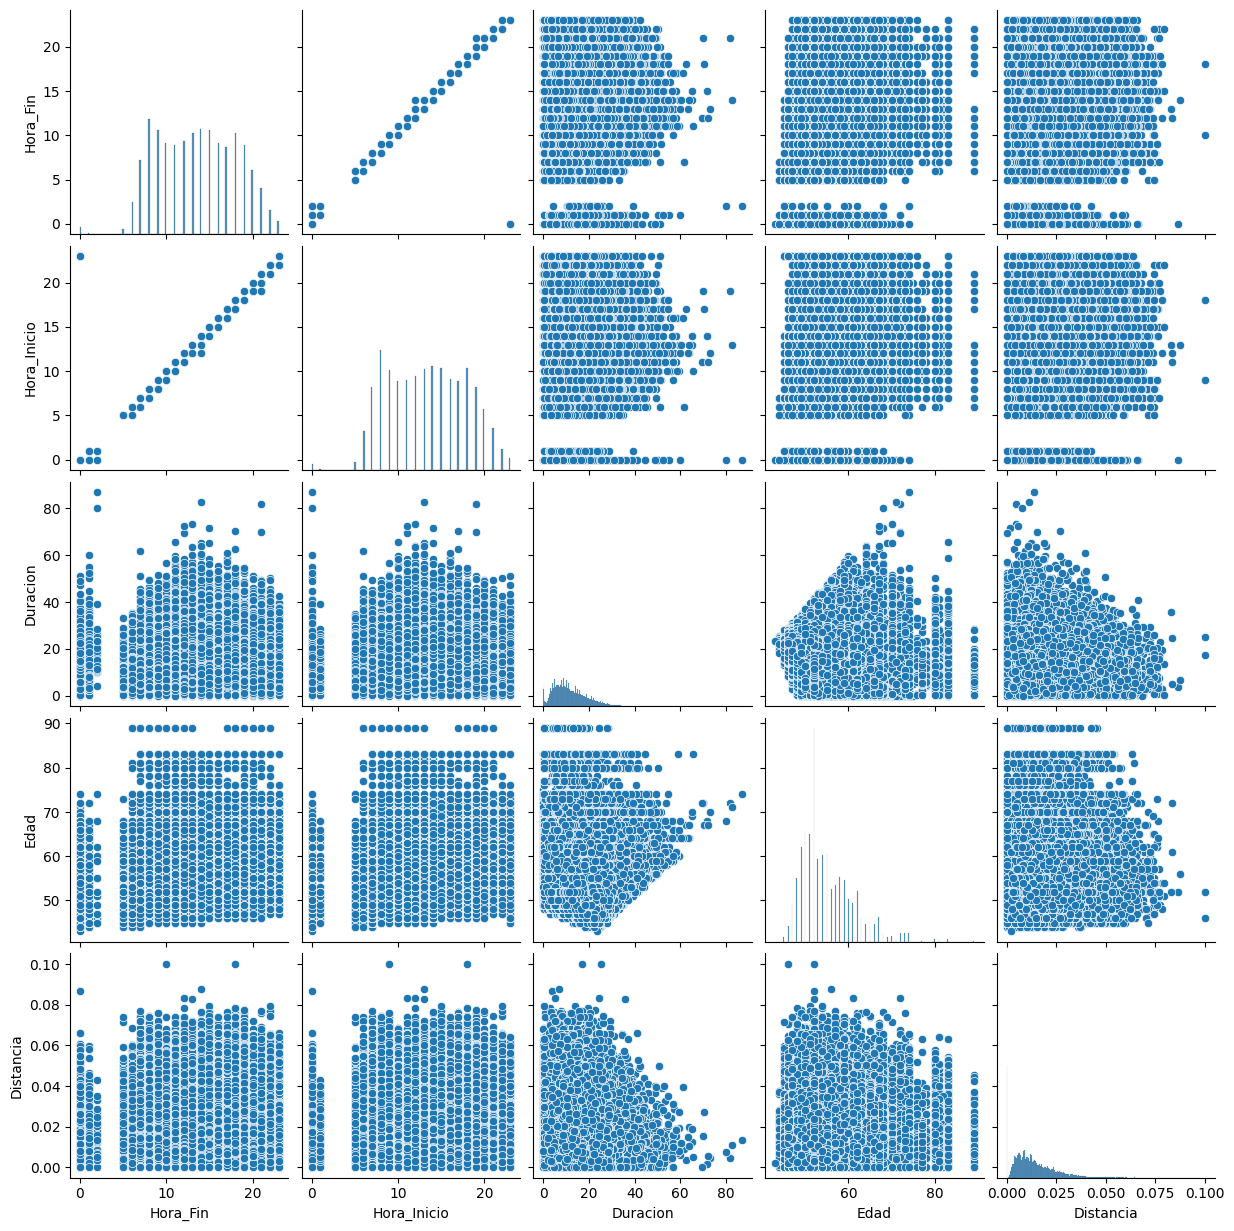

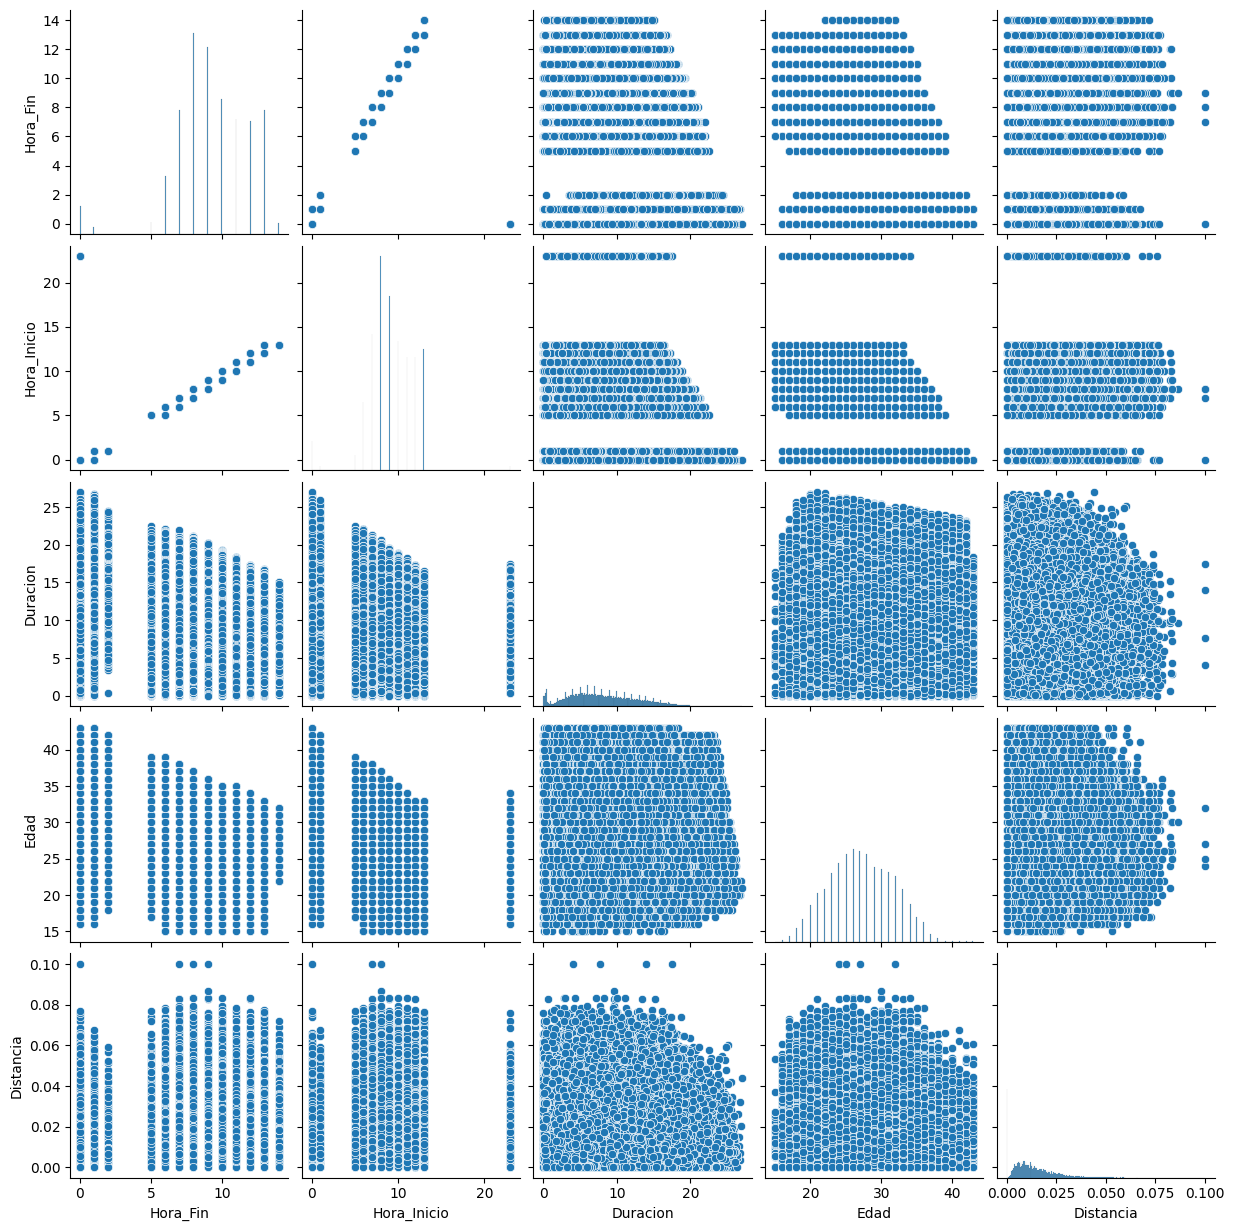

In [29]:
for i in range(k):
    print(df_new[['Genero', 'Hora_Fin', 'Hora_Inicio', 'Duracion', 'Edad', 'Distancia']][df_new['labels']==i].mean())

    ploteado = sns.pairplot(df_new[['Hora_Fin', 'Hora_Inicio', 'Duracion', 'Edad', 'Distancia']][df_new['labels']==i])
    plt.savefig(r"C:\Users\merce\Downloads\K_means_5_{}.png".format(i), dpi=300)